In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal
# import torch
# from torch.nn import functional as F

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

from thefuzz import fuzz
from scipy.optimize import linear_sum_assignment

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\anwan\anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
_imgsize = (6,6)
def showx(im, cover=None):
    plt.figure(figsize=_imgsize)
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)

def highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return showx(img)
    
def show(im):
    return Image.fromarray(im)

def show_region(base, region, rad=500):
#     region = regions[ind]
    y1, x1, y2, x2 = region.bbox
    x, y = x1, y1
    h = y2 - y1
    w = x2 - x1
    cy, cx = region.centroid

    showx(base)

    r = rad
    if h < r:
        h = r
        y = cy - r / 2
    if w < r:
        w = r
        x = cx - r / 2

    plt.xlim(x, x + w)
    plt.ylim(y + h, y)

In [3]:
root = Path('extra/balkans')

# mono_path = root / 'wd_mono.png'
color_path = root / 'borders.png'

<IPython.core.display.Javascript object>


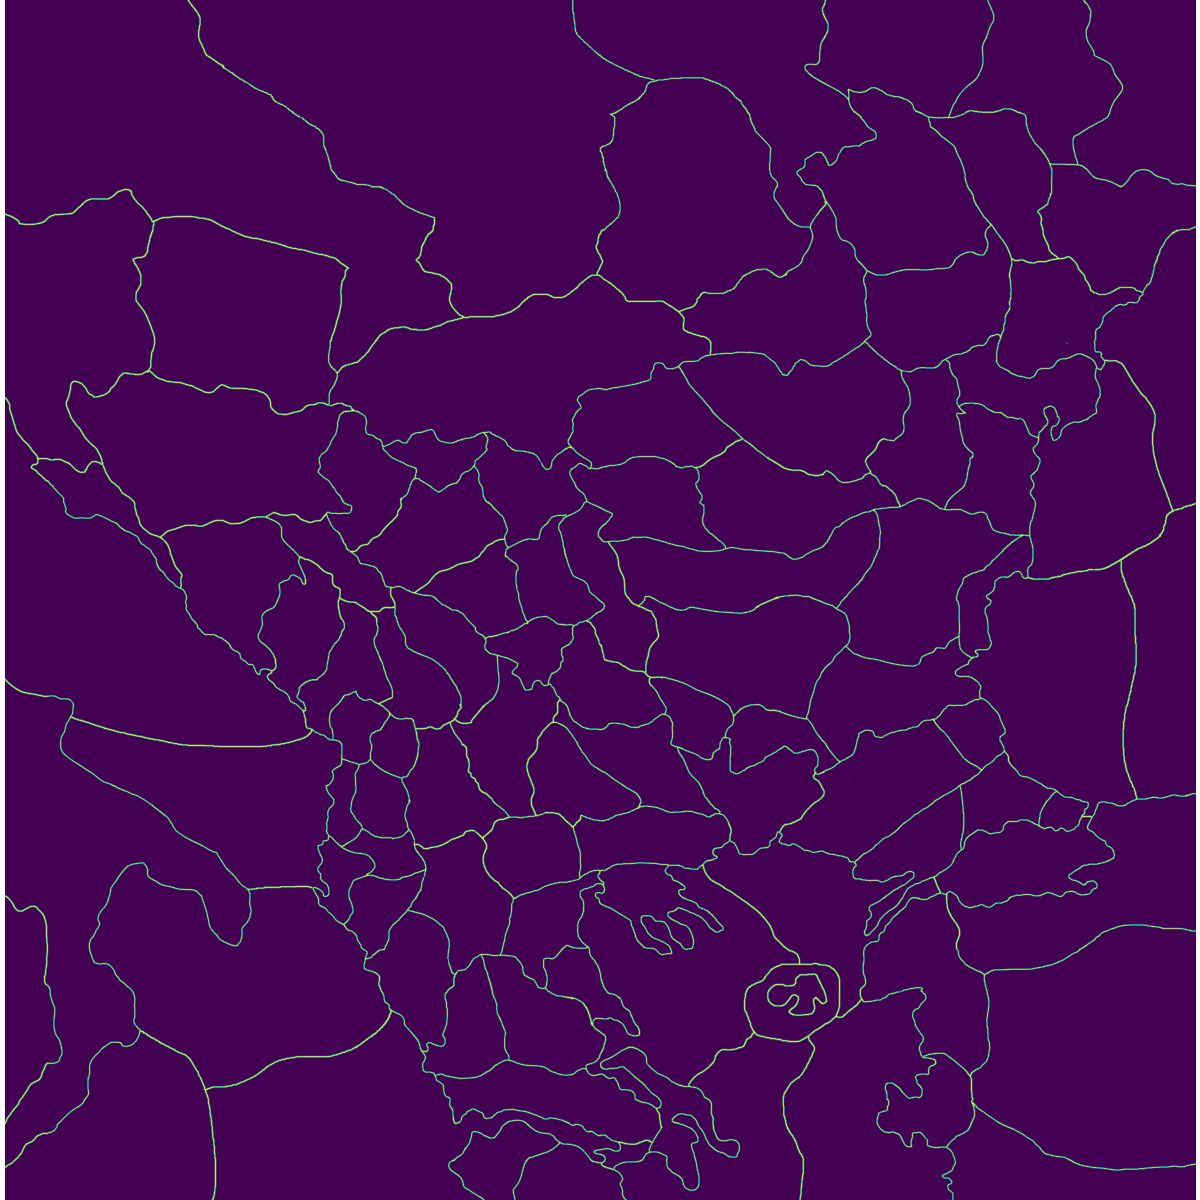

In [4]:
im = Image.open(color_path).convert('RGBA')
im = np.asarray(im)
rgb = im[...,:3]
# show(im)
showx(rgb)

In [5]:
border_color = [0,0,0]
bcolor = hex_to_rgb(border_color) if isinstance(border_color, str) else border_color
bcolor = np.array(bcolor).reshape(1,1,-1)

border = np.abs(rgb - bcolor).sum(-1) == 0
border.shape

(4442, 4405)

In [6]:
# plt.imshow(border);

In [162]:
bds = (im[...,:3]<3).astype(int).sum(-1)==3
# showx(bds)

# Filling in Missing Boundaries

In [163]:
# def old_fill_diagonals(img):
#     H, W = img.shape
#     kernel = np.array([[0,1,0,1,0],
#                    [1,1,1,1,1],
#                    [0,1,1,1,0],
#                    [1,1,1,1,1],
#                    [0,1,0,1,0]])
#     out = F.conv_transpose2d(torch.from_numpy(img).view(1,1,H, W).float(), torch.from_numpy(kernel).view(1,1,5,5).float(), stride=3, padding=1).int().squeeze().numpy().astype(bool).astype(int)
#     out -= 1
#     out = out.astype(bool).astype(int)
#     return out

def fill_diagonals(img):
    H, W = img.shape
    kernel = np.array([[0,1,0,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,0,1,0]])
    out = cov_transpose(img, kernel, stride=3, padding=1)
    out = np.logical_not(out)
    out = out.astype(bool).astype(int)
    return out
	
	
def cov_transpose(img, kernel, stride, padding):
    # Ensure type is bool
    img = img.astype('bool')
    kernel = kernel.astype('bool')
    
    # Extension
    out = np.repeat(img, stride, axis=0) # Duplicate rows
    out = np.repeat(out, stride, axis=1) # Duplicate columns

    # Padding
    out = np.pad(out, (padding, padding), 'constant', constant_values=(0, 0))
    
    # Window
    view = np.lib.stride_tricks.sliding_window_view(out, window_shape=kernel.shape, writeable=True) # stride = 1 by default
    view = view[::stride, ::stride]
    
    # Mask - only apply pattern if center == 1
    middle = int(np.floor(kernel.shape[0] / 2)) # center of kernel
    mask = view[:, :, middle, middle] == 1
    
    # Apply kernel
    view[mask] = view[mask] | kernel
    
    # Cut off padding
    out = out[1:-1, 1:-1]
    
    return out

In [164]:
sep = im[...,:3].copy().astype(int)
vdiff = sep[1:] - sep[:-1]
hdiff = sep[:,1:] - sep[:,:-1]
vdiff = np.abs(vdiff).sum(-1).astype(bool)#.astype(int)
hdiff = np.abs(hdiff).sum(-1).astype(bool)#.astype(int)
vdiff.shape, hdiff.shape

((4441, 4405), (4442, 4404))

In [165]:
bds = sep.sum(-1)==0
vdiff[bds[1:]] = 0
vdiff[bds[:-1]] = 0
hdiff[bds[:,1:]] = 0
hdiff[bds[:,:-1]] = 0

In [166]:
sep[1:][vdiff] = 0
sep[:-1][vdiff] = 0
sep[:,1:][hdiff] = 0
sep[:,:-1][hdiff] = 0

In [167]:
white = np.abs(sep - 255).sum(-1)==0
# showx(white)
white.sum()

0

<IPython.core.display.Javascript object>


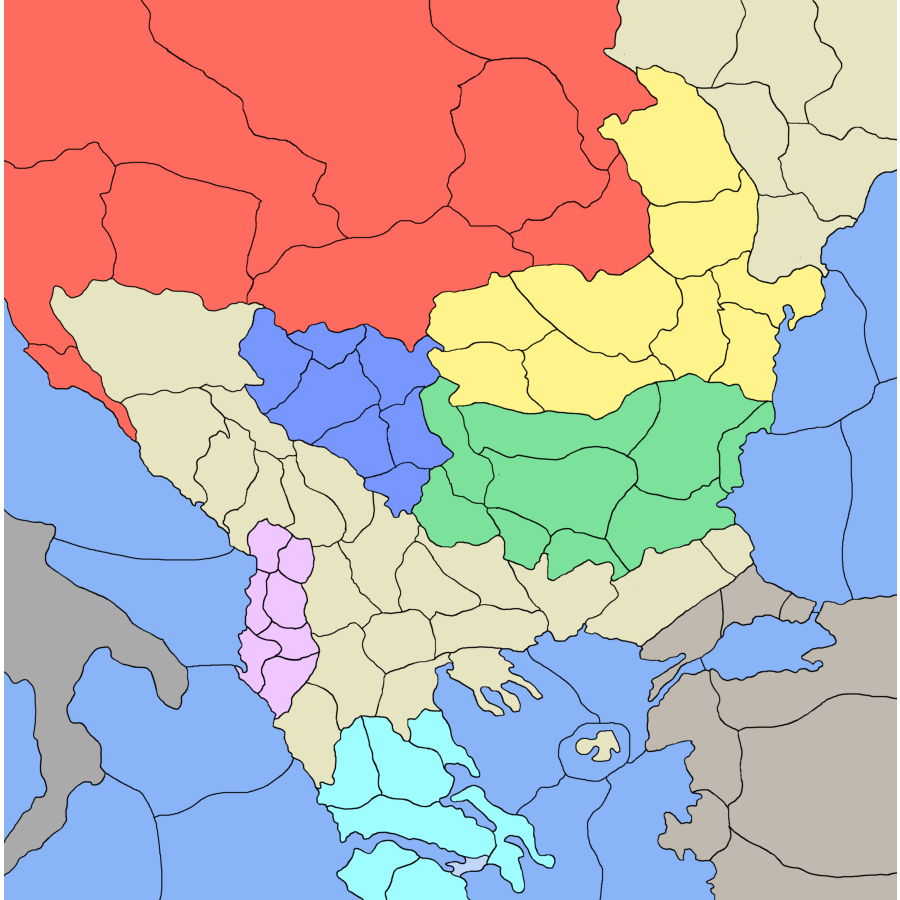

In [168]:
sep[white] = 0
showx(sep)

# Filling in Diagonals

In [169]:
# bds = im[...,:3].sum(-1)==0
bds = sep.sum(-1)==0
bds.shape

(4442, 4405)

In [170]:
strt = fill_diagonals(bds)
strt.shape

(13326, 13215)

In [171]:
# showx(bds)

In [172]:
slbls = label(strt)[1::3, 1::3]
# showx(slbls)
slbls.shape, slbls.max()

((4442, 4405), 153)

In [173]:
def showx(im, cover=slbls):
    plt.figure(figsize=_imgsize)
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)


In [174]:
# showx(slbls*10)

# Identify Labels

In [175]:
labels_path = root / 'labels.png'
names = None

In [176]:
lm = Image.open(labels_path).convert('RGBA')
lm = np.asarray(lm)

blbls = lm[...,-1].astype(bool) * slbls
lm = 255 - np.stack([lm[...,-1]]*3,-1)

# show(lm)
# showx(seq>0)

In [177]:
existing = set(blbls.reshape(-1).tolist())
existing.discard(0)
existing = list(existing)
len(existing)

97

In [178]:
# highlight(lm, expand_labels(blbls>0, 50));

In [193]:
from PIL import Image, ImageOps

In [129]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

def _get_label_pixels(idx, scale=1):
    rmin, rmax, cmin, cmax = bbox2(blbls==idx)
    name = lm[rmin:rmax, cmin:cmax,:3]
    H, W = name.shape[:2]
    img = cv2.resize(name, (scale*W, scale*H), interpolation=cv2.INTER_CUBIC)
    H, W = img.shape[:2]
    im = show(img)
    result = Image.new(im.mode, (2*W, 2*H), (255, 255, 255))
    result.paste(im, (W//2, H//2))
    
    return np.array(result)

try:
    import pytesseract
    # os.environ['PATH'] += ';C:\\Users\\anwan\\AppData\\Local\\Programs\\Tesseract-OCR'
    def _infer_name(img):
        return pytesseract.image_to_string(show(img)).strip().upper()

except ImportError:
    def _infer_name(img):
        return ''
    
def compress_to_bytes(data, fmt):
    """
    Helper function to compress image data via PIL/Pillow.
    """
    buff = io.BytesIO()
    img = Image.fromarray(data)    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

YMP


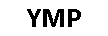

In [130]:
img = _get_label_pixels(random.choice(existing), 1)
txt = _infer_name(img)
print(txt)
show(img)

In [131]:
# infers = [_infer_name(_get_label_pixels(x)) for x in tqdm(existing)]
# len(infers)
# name_path = root / 'REGIONNAMESS.txt'
# with name_path.open('r') as f:
#     raw = f.read()
# rawnames = [r.strip() for r in raw.split('\n')]
# basenames = list(set(x.split('-')[0] for x in rawnames))
# len(basenames)
# n1, n2 = np.array(infers), np.array(basenames)
# R = np.array([[fuzz.ratio(i,j) for j in n2] for i in n1])
# R.shape
# rs, cs = linear_sum_assignment(-R)

In [179]:
matches = [None]*(slbls.max()+1)

In [180]:
todo = iter(tqdm([i for i in existing if matches[i] is None]))
prompt = widgets.Label()
displblimg = widgets.Image()
textbox = widgets.Text()
response = widgets.Label()

def _update_display():
    try:
        current = next(todo)
    except StopIteration:
        clear_output()
        print('Done!')
        print(matches)
    else:
        prompt.index = current
        prompt.value = f'matches[{current}] = '
        img = _get_label_pixels(current)
        displblimg.value = compress_to_bytes(img,fmt='png')
        textbox.value = _infer_name(img)

def _on_submit_func(sender):
    idx = prompt.index
    matches[idx] = textbox.value
    response.value = f'Set matches[{idx}] = {repr(matches[idx])}'
    _update_display()
textbox.on_submit(_on_submit_func)

display(displblimg, widgets.HBox([prompt, textbox]), response)
_update_display()

  0%|          | 0/97 [00:00<?, ?it/s]

Image(value=b'')

Label(value='')

In [328]:
# matches = [None, 'POZ', 'OSJ', 'YAR', 'YMP', 'FLO', 'UNE', 'SIG', 'SUC', 'CHI', None, 'ODS', 'CRO', 'TRA', 'BOS', None, 'SBL', 'RCO', None, None, None, None, None, 'LBE', 'NVS', 'TUL', 'POI', None, None, 'BRA', 'RMC', 'RES', None, 'SAR', 'NAD', 'CNT', 'SAB', 'BEL', 'NEG', 'CRA', 'BUC', 'SPL', None, 'KRA', None, None, None, None, 'SIL', 'SOF', 'TCS', None, None, 'PLE', 'NOV', 'NIS', 'SBO', 'VAR', None, 'PRO', None, 'CET', 'BGC', 'KRI', None, 'TIR', 'SMO', None, 'KRU', None, 'VRA', 'DUB', None, 'STA', 'OHR', None, 'SAM', None, 'LEZ', 'KIR', 'BAN', None, 'PLO', 'PRI', 'CAD', 'ADR', 'STR', 'SGA', 'PAM', 'ROD', None, 'DUR', 'TRN', None, None, None, None, None, 'ENO', 'CON', 'BRS', 'KAV', 'MON', 'DAR', None, 'VAL', 'KOR', 'TEP', None, None, None, 'VLR', 'AIC', 'SAL', 'SIA', 'PER', 'VER', 'KAL', None, None, 'IOA', None, None, None, 'CAT', None, None, 'LAR', None, 'PAT', 'TRK', 'LES', None, None, 'CES', None, None, 'GCO', None, 'ION', 'MIK', 'ATH', 'SMY', None, None, None, 'EPI', None, 'SAN', None, 'PAS', 'CNC', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
matches = [None, 'POZ', 'OSJ', 'YAR', 'YMP', 'FLO', 'UNE', 'SIG', 'SUC', 'CHI', None, 'ODS', 'CRO', 'TRA', 'BOS', None, 'SBL', 'RCO', None, None, None, None, None, 'LBE', 'NVS', 'TUL', 'POI', None, None, 'BRA', 'RMC', 'RES', None, 'SAR', 'NAD', 'CNT', 'SAB', 'BEL', 'NEG', 'CRA', 'BUC', 'SPL', None, 'KRA', None, None, None, None, 'SIL', 'SOF', 'TCS', None, None, 'PLE', 'NOV', 'NIS', 'SBO', 'VAR', None, 'PRO', None, 'CET', 'BGC', 'KRI', None, 'TIR', 'SMO', None, 'KRU', None, 'VRA', 'DUB', None, 'STA', 'OHR', None, 'SAM', None, 'LEZ', 'KIR', 'BAN', None, 'PLO', 'PRI', 'CAD', 'ADR', 'STR', 'SGA', 'PAM', 'ROD', None, 'DUR', 'TRN', None, None, None, None, None, 'ENO', 'CON', 'BRS', 'KAV', 'MON', 'DAR', None, 'VAL', 'KOR', 'TEP', None, None, None, 'VLR', 'AIC', 'SAL', 'SIA', 'PER', 'VER', 'KAL', None, None, 'IOA', None, None, None, 'CAT', None, None, 'LAR', None, 'PAT', 'TRK', 'LES', None, None, 'CES', None, None, 'GCO', None, 'ION', 'MIK', 'ATH', 'SMY', None, None, None, 'EPI', None, 'SAN', None, 'PAS', None, 'CNC', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
# matches = [None, 'POZ', 'OSJ', 'YAR', 'YMP', 'FLO', 'UNE', 'SIG', 'SUC', 'CHI', None, 'ODS', 'CRO', 'TRA', 'BOS', None, 'SBL', 'RCO', None, None, None, None, None, 'LBE', 'NVS', 'TUL', 'POI', None, None, 'BRA', 'RMC', 'RES', None, 'SAR', 'NAD', 'CNT', 'SAB', 'BEL', 'NEG', 'CRA', 'BUC', 'SPL', None, 'KRA', None, None, None, None, 'SIL', 'SOF', 'TCS', None, None, 'PLE', 'NOV', 'NIS', 'SBO', 'VAR', None, 'PRO', None, 'CET', 'BGC', 'KRI', None, 'TIR', 'SMO', None, 'KRU', None, 'VRA', 'DUB', None, 'STA', 'OHR', None, 'SAM', None, 'LEZ', 'KIR', 'BAN', None, 'PLO', 'PRI', 'CAD', 'ADR', 'STR', 'SGA', 'PAM', 'ROD', None, 'DUR', 'TRN', None, None, None, None, None, 'ENO', 'CON', 'BRS', 'KAV', 'MON', 'DAR', None, 'VAL', 'KOR', 'TEP', None, None, None, 'VLR', 'AIC', 'SAL', 'SIA', 'PER', 'VER', 'KAL', None, None, 'IOA', None, None, None, 'CAT', None, None, 'LAR', None, 'PAT', 'TRK', 'LES', None, None, 'CES', None, None, 'GCO', None, 'ION', 'MIK', 'ATH', 'SMY', None, None, None, 'EPI', None, 'SAN', None, 'PAS', None, 'CNC', None]

matches[132] = matches[131]
# matches[131] = f'{matches[132]}-water'
matches[131] = None

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


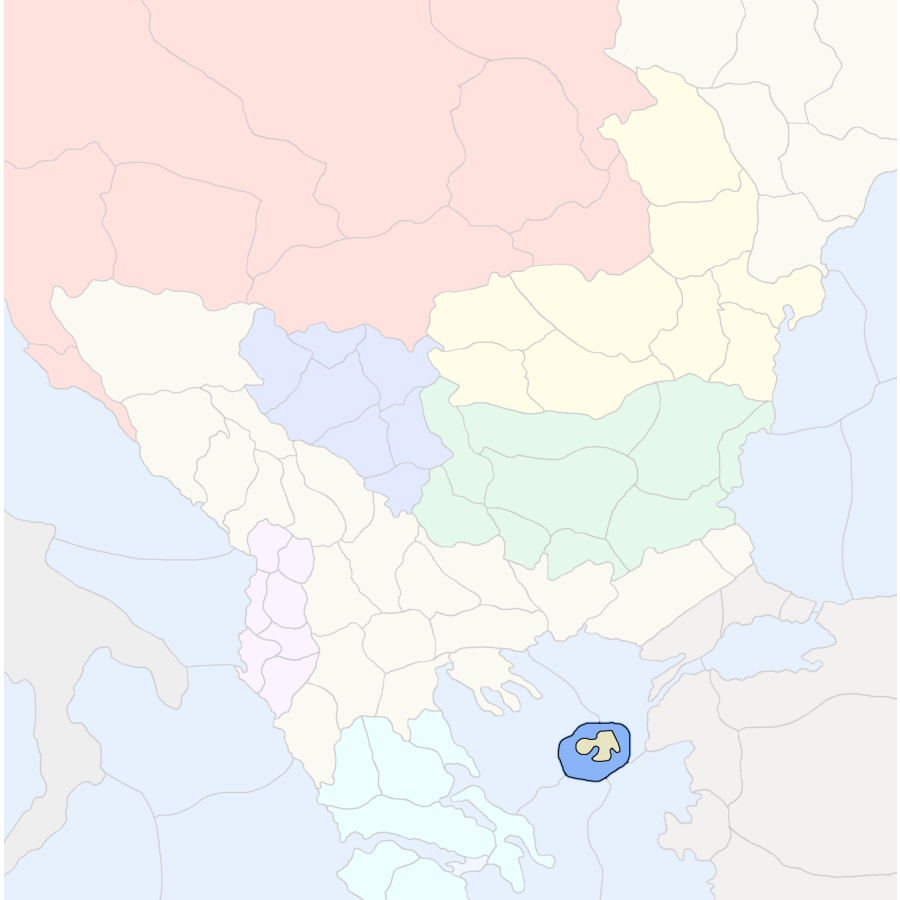

In [312]:
highlight(sep, expand_labels(sum(slbls==i for i in tqdm([132, 131])), 10))

# Connect tiles -> Regions

In [330]:
unknown = [i for i, x in enumerate(matches) if x is None and i != 0]
print(unknown)

[10, 15, 18, 19, 20, 21, 22, 27, 28, 32, 42, 44, 45, 46, 47, 51, 52, 58, 60, 64, 67, 69, 72, 75, 77, 81, 90, 93, 94, 95, 96, 97, 104, 108, 109, 110, 118, 119, 121, 122, 123, 125, 126, 128, 131, 133, 135, 136, 138, 143, 144, 145, 147, 149, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]


  0%|          | 0/86 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


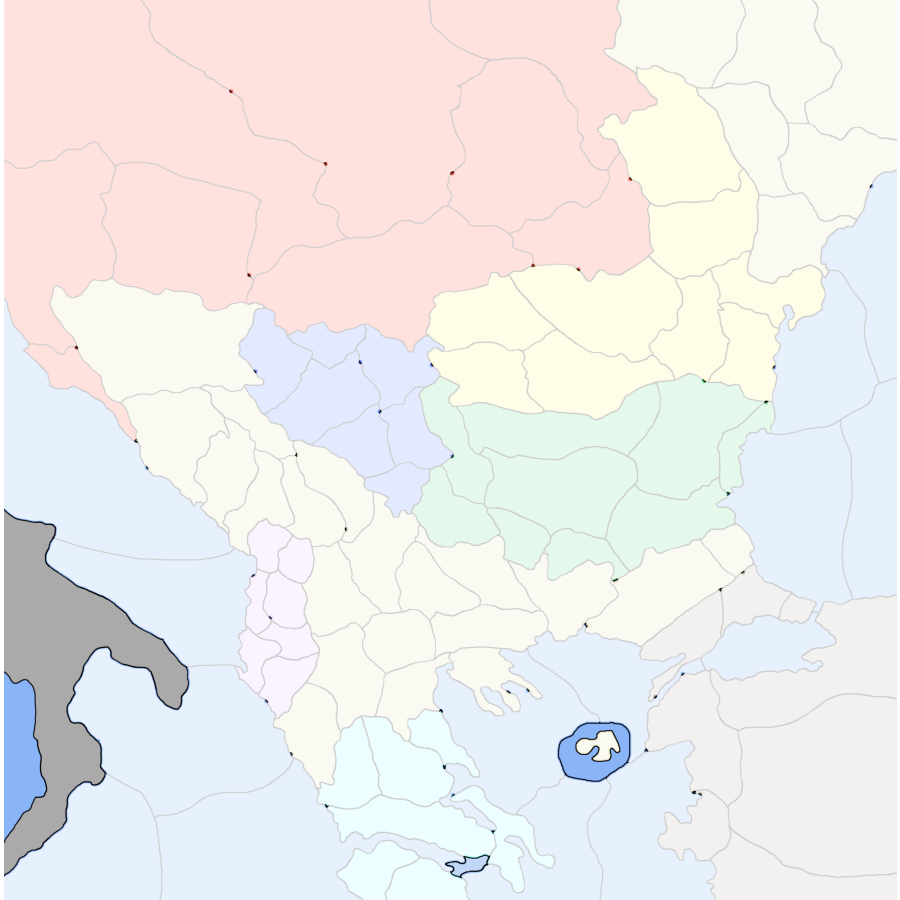

In [331]:
highlight(sep, expand_labels(sum(slbls==i for i in tqdm(unknown)), 10))

In [334]:
# specified manually
skip = {77, 118, 131, 151}

  0%|          | 0/82 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


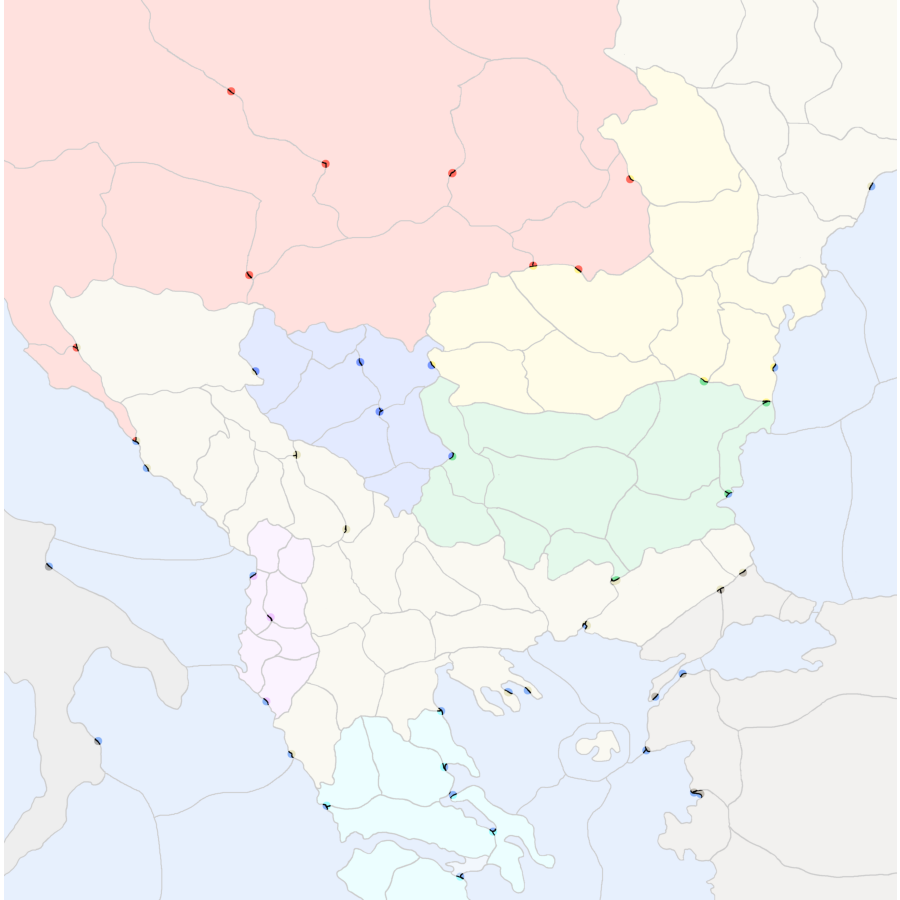

82

In [335]:
noise = [i for i in unknown if i not in skip]
highlight(sep, expand_labels(sum(slbls==i for i in tqdm(noise)), 20))
len(noise)

In [337]:
fixes = {}

In [338]:
def extract_colors(mask):
    return Counter(map(tuple, rgb[mask].tolist()))

In [339]:
for idx in tqdm([n for n in noise if n not in fixes]):
    options = extract_colors(slbls==idx)
    if len(options):
        mask = None
        for c in options:
            c = np.array(c).reshape(1,1,-1)
            new = (rgb-c).sum(-1) == 0
            if mask is None:
                mask = new
            else:
                mask += new
        mask = mask.astype(bool)
        # highlight(rgb, mask)

        sel = slbls==idx
        for i in (range(5)):
            locs = set(slbls[expand_labels(sel, i*2+1) * mask].tolist())
            locs.discard(0)
            locs.discard(idx)
            if len(locs):
                break
        fixes[idx] = locs.pop() if len(locs) else None
len(fixes)

  0%|          | 0/82 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [346]:
fixes = {10: 2, 15: None, 18: None, 19: None, 20: None, 21: 13, 22: 17, 27: 13, 28: 13, 32: 1, 42: None, 44: 38, 45: 38, 46: 30, 47: 36, 51: 48, 52: 48, 58: 57, 60: 59, 64: 56, 67: 63, 69: 55, 72: 34, 75: 73, 81: None, 90: 77, 93: 89, 94: 91, 95: 85, 96: 85, 97: 89, 104: 92, 108: 109, 109: 108, 110: 109, 119: 107, 121: 114, 122: 113, 123: 113, 125: 98, 126: 112, 128: 127, 133: 112, 135: 134, 136: None, 138: 127, 143: 142, 144: 142, 145: 114, 147: 129, 149: None, 153: None}
for idx, src in fixes.items():
    matches[idx] = src if src is None else matches[src]
# print(matches)
matches = [None, 'POZ', 'OSJ', 'YAR', 'YMP', 'FLO', 'UNE', 'SIG', 'SUC', 'CHI', 'OSJ', 'ODS', 'CRO', 'TRA', 'BOS', None, 'SBL', 'RCO', None, None, None, 'TRA', 'RCO', 'LBE', 'NVS', 'TUL', 'POI', 'TRA', 'TRA', 'BRA', 'RMC', 'RES', 'POZ', 'SAR', 'NAD', 'CNT', 'SAB', 'BEL', 'NEG', 'CRA', 'BUC', 'SPL', None, 'KRA', 'NEG', 'NEG', 'RMC', 'SAB', 'SIL', 'SOF', 'TCS', 'SIL', 'SIL', 'PLE', 'NOV', 'NIS', 'SBO', 'VAR', 'VAR', 'PRO', 'PRO', 'CET', 'BGC', 'KRI', 'SBO', 'TIR', 'SMO', 'KRI', 'KRU', 'NIS', 'VRA', 'DUB', 'NAD', 'STA', 'OHR', 'STA', 'SAM', None, 'LEZ', 'KIR', 'BAN', None, 'PLO', 'PRI', 'CAD', 'ADR', 'STR', 'SGA', 'PAM', 'ROD', None, 'DUR', 'TRN', 'ROD', 'DUR', 'ADR', 'ADR', 'ROD', 'ENO', 'CON', 'BRS', 'KAV', 'MON', 'DAR', 'TRN', 'VAL', 'KOR', 'TEP', None, None, None, 'VLR', 'AIC', 'SAL', 'SIA', 'PER', 'VER', 'KAL', None, 'TEP', 'IOA', 'SIA', 'SAL', 'SAL', 'CAT', 'ENO', 'AIC', 'LAR', 'LAR', 'PAT', 'TRK', None, 'LES', 'AIC', 'CES', 'CES', None, 'GCO', 'LAR', 'ION', 'MIK', 'ATH', 'SMY', 'SMY', 'SMY', 'SIA', 'EPI', 'PAT', 'SAN', None, 'PAS', None, 'CNC', None]

In [349]:
groups = {}
for i, n in enumerate(matches):
    if i > 0:
        if n not in groups:
            groups[n] = []
        groups[n].append(i)
bg_groups = groups[None]
del groups[None]        
len(groups)

97

In [350]:
regs = []
for n, ts in groups.items():
    regs.append({'ID': len(regs)+1, 'tiles': ts, 'name': n})
bgs = []
for i, t in enumerate(bg_groups):
    bgs.append({'ID': len(bgs)+len(regs)+1, 'tiles': [t], 'name': f'bg{i}'})
rIDs = {r['ID']:r for rs in [regs, bgs] for r in rs}
len(rIDs)

114

In [351]:
rlbls = slbls * 0
for reg in tqdm(regs):
    for t in reg['tiles']:
        rlbls[slbls==t] = reg['ID']
for reg in tqdm(bgs):
    for t in reg['tiles']:
        rlbls[slbls==t] = reg['ID']

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


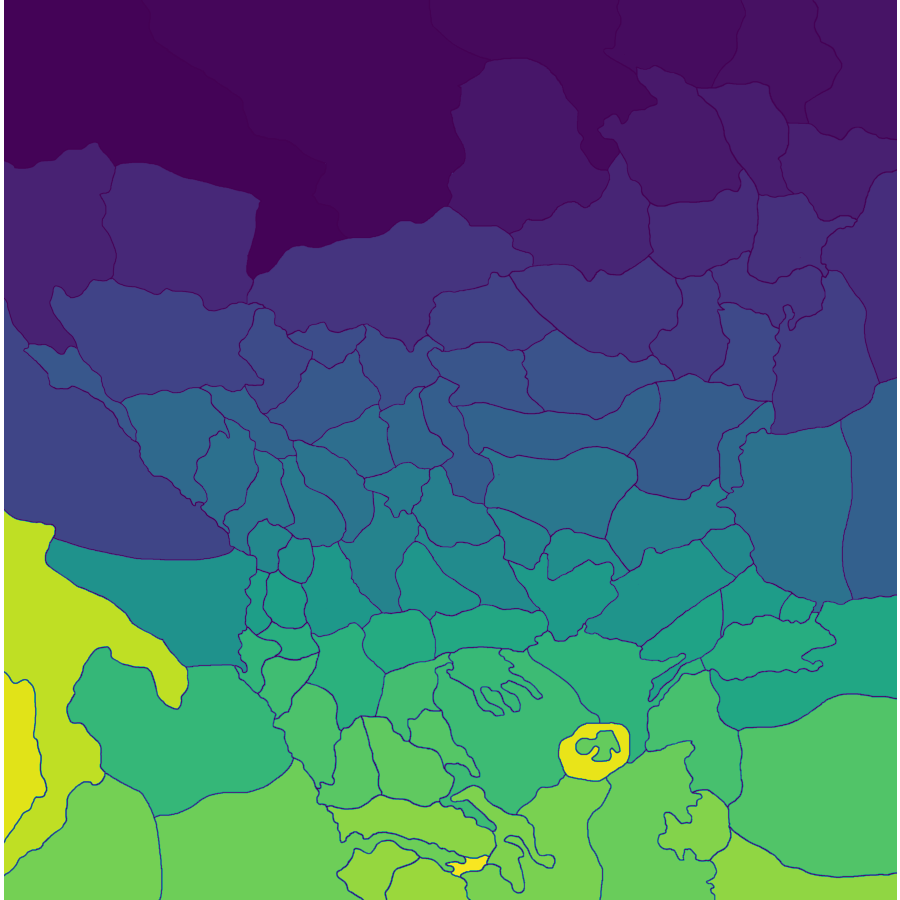

In [352]:
showx(rlbls, rlbls)

In [353]:
Image.fromarray(slbls.astype(np.int16)).save(root / "tiles.png")
Image.fromarray(rlbls.astype(np.int16)).save(root / "regions.png")

In [354]:
sea = set(extract_colors(slbls==34))
sea

{(138, 180, 248)}

In [355]:
for reg in tqdm(regs):
    if extract_colors(rlbls==reg['ID']).most_common()[0][0] in sea:
        reg['env'] = 'sea'
    else:
        reg['env'] = 'land'

  0%|          | 0/97 [00:00<?, ?it/s]

In [356]:
regs

[{'ID': 1, 'tiles': [1, 32], 'name': 'POZ', 'env': 'land'},
 {'ID': 2, 'tiles': [2, 10], 'name': 'OSJ', 'env': 'land'},
 {'ID': 3, 'tiles': [3], 'name': 'YAR', 'env': 'land'},
 {'ID': 4, 'tiles': [4], 'name': 'YMP', 'env': 'land'},
 {'ID': 5, 'tiles': [5], 'name': 'FLO', 'env': 'land'},
 {'ID': 6, 'tiles': [6], 'name': 'UNE', 'env': 'land'},
 {'ID': 7, 'tiles': [7], 'name': 'SIG', 'env': 'land'},
 {'ID': 8, 'tiles': [8], 'name': 'SUC', 'env': 'land'},
 {'ID': 9, 'tiles': [9], 'name': 'CHI', 'env': 'land'},
 {'ID': 10, 'tiles': [11], 'name': 'ODS', 'env': 'land'},
 {'ID': 11, 'tiles': [12], 'name': 'CRO', 'env': 'land'},
 {'ID': 12, 'tiles': [13, 21, 27, 28], 'name': 'TRA', 'env': 'land'},
 {'ID': 13, 'tiles': [14], 'name': 'BOS', 'env': 'land'},
 {'ID': 14, 'tiles': [16], 'name': 'SBL', 'env': 'land'},
 {'ID': 15, 'tiles': [17, 22], 'name': 'RCO', 'env': 'sea'},
 {'ID': 16, 'tiles': [23], 'name': 'LBE', 'env': 'land'},
 {'ID': 17, 'tiles': [24], 'name': 'NVS', 'env': 'land'},
 {'ID': 1

In [357]:
save_yaml(regs, root / "nodes.yaml")
save_yaml(bgs, root / "bgs.yaml")